In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, plot_roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, confusion_matrix

import time
import datetime

print(datetime.datetime.now())

2023-06-21 14:48:54.438275


In [2]:
path_data = '../data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_trainingResults = path_data + 'trainingResults_binary80_s20230504.p'

# OUTPUTS
fn_predictionsValidation = path_data + 'predictionscACLD_binary_s20230508.xlsx'
fn_figure_auc_final = '../figures/f_auroc_finalcACLD_s20230508.png'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['font.size'] = 10
plt.rcParams['figure.autolayout']=False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
with open(fn_trainingResults, "rb") as input_file:
    trainingResults = pickle.load(input_file)

trainingResults.keys()

dict_keys(['importances_all', 'importances_kept', 'feat2keep', 'groups', 'model_rf_ovr'])

In [ ]:
temp = dict_data['df_metadata']
#temp[temp['decompBL']==False]

In [6]:
# collect features of testing set
testFeatures = dict_data['df_zscoreFeatures_validation'][trainingResults['feat2keep']]


# # list of patients in test cohort with 'decomp at BL yes(1) no (0)']=='0'
# # generated in misc_counting_s20220204.ipynb
cACLD_testIDs = ['0058', '0098', '0118', '0181', '0206', '0213', '0224', '0241', '0244',
       '0257', '0272', '0284', '0298', '0302', '0307', '0334', '0340', '0373',
       '0383', '0395', '0408', '0413', '0445', '0451', '0459', '0475', '0487',
       '0498']

testFeatures = testFeatures[testFeatures.index.isin(cACLD_testIDs)]

# collect labels of testing set
tempMeta = dict_data['df_metadata']
currMeta = tempMeta[tempMeta.index.isin(testFeatures.index)]
currMeta['hvpg_corrected'] = currMeta['hvpg_corrected'].fillna(0).astype(int)
currMeta['HVPG_toPredict'] = currMeta['hvpg_corrected'].apply(lambda x: 0 if x < 10 else 1)

testLabels = currMeta['HVPG_toPredict']

# binarize testing labels
y = label_binarize(testLabels, classes=[0, 1, 2])
n_classes = y.shape[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
print(sum(testLabels==0))
print(sum(testLabels==1))
print(sum(testLabels==2))

16
12
0


In [8]:
# run model
frSave = trainingResults['model_rf_ovr']

predClasses = frSave.predict(testFeatures)
probabilities = frSave.predict_proba(testFeatures)
predictions = probabilities[:,1]

y_test = testLabels

In [9]:
# calculate truth table
tn, fp, fn, tp = confusion_matrix(y_test, predClasses).ravel()

ppv = tp / (tp+fp)
npv = tn / (tn+fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp+tn) / (tp+tn+fp+fn)

posLR = sensitivity / (1 - specificity)
negLR = (1 - sensitivity) / specificity

#
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

predClasses = frSave.predict(testFeatures)
precision = precision_score(testLabels, predClasses)

In [10]:
print('auc: ' + str(roc_auc))
print('sensitivity: ' + str(sensitivity))
print('specificity: ' + str(specificity))
print('accuracy: ' + str(accuracy))
print('ppv: ' + str(ppv))
print('npv: ' + str(npv))

auc: 0.84375
sensitivity: 0.8333333333333334
specificity: 0.75
accuracy: 0.7857142857142857
ppv: 0.7142857142857143
npv: 0.8571428571428571


In [11]:
n_bootstrap = 10000
auroc_boot = np.zeros(n_bootstrap)
sensitivity_boot = np.zeros(n_bootstrap)
specificity_boot = np.zeros(n_bootstrap)
ppv_boot = np.zeros(n_bootstrap)
npv_boot = np.zeros(n_bootstrap)
accuracy_boot = np.zeros(n_bootstrap)
posLR_boot = np.zeros(n_bootstrap)
negLR_boot = np.zeros(n_bootstrap)


# same as before
y_test = testLabels
probabilities = frSave.predict_proba(testFeatures)
predictions = probabilities[:,1]
predClasses = frSave.predict(testFeatures)

for i in range(n_bootstrap):
    # Create a new bootstrap sample
    idx_boot = np.random.choice(len(y_test), len(y_test), replace=True)
    labels_boot = y_test[idx_boot]
    prob_boot = predictions[idx_boot]
    pred_boot = predClasses[idx_boot]

    # Calculate the AUROC
    auroc_boot[i] = roc_auc_score(labels_boot, prob_boot)
    
    # other metrics
    tn, fp, fn, tp = confusion_matrix(labels_boot, pred_boot).ravel()

    ppv_boot[i] = tp / (tp+fp)
    npv_boot[i] = tn / (tn+fn)

    sensitivity_boot[i] = tp / (tp + fn)
    specificity_boot[i] = tn / (tn + fp)
    accuracy_boot[i] = (tp+tn) / (tp+tn+fp+fn)

    posLR_boot[i] = sensitivity_boot[i] / (1 - specificity_boot[i])
    negLR_boot[i] = (1 - sensitivity_boot[i]) / specificity_boot[i]

# Step 5: Calculate the confidence interval based on the distribution of AUROC values
lower_auc = np.percentile(auroc_boot, 2.5)
upper_auc = np.percentile(auroc_boot, 97.5)
print("auc [95%CI: {:.3f}-{:.3f}]".format(lower_auc, upper_auc))

lower_sen = np.percentile(sensitivity_boot, 2.5)
upper_sen = np.percentile(sensitivity_boot, 97.5)
print("sensitivity [95%CI: {:.3f}-{:.3f}]".format(lower_sen, upper_sen))

lower_spe = np.percentile(specificity_boot, 2.5)
upper_spe = np.percentile(specificity_boot, 97.5)
print("specificity [95%CI: {:.3f}-{:.3f}]".format(lower_spe, upper_spe))

lower_ppv = np.percentile(ppv_boot, 2.5)
upper_ppv = np.percentile(ppv_boot, 97.5)
print("ppv [95%CI: {:.3f}-{:.3f}]".format(lower_ppv, upper_ppv))

lower_npv = np.percentile(npv_boot, 2.5)
upper_npv = np.percentile(npv_boot, 97.5)
print("npv [95%CI: {:.3f}-{:.3f}]".format(lower_npv, upper_npv))

lower_acc = np.percentile(accuracy_boot, 2.5)
upper_acc = np.percentile(accuracy_boot, 97.5)
print("accuracy [95%CI: {:.3f}-{:.3f}]".format(lower_acc, upper_acc))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_

auc [95%CI: 0.667-0.979]
sensitivity [95%CI: 0.600-1.000]
specificity [95%CI: 0.529-0.941]
ppv [95%CI: 0.462-0.929]
npv [95%CI: 0.643-1.000]
accuracy [95%CI: 0.643-0.929]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


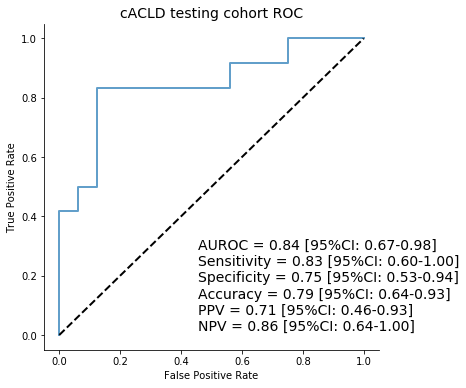

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

labelTxt = 'AUROC = %0.2f \n ppv = %0.2f \n npv = %0.2f \n +LR = %0.2f \n -LR = %0.2f' % (roc_auc, ppv, npv, posLR, negLR)

plt.plot(fpr, tpr, color='tab:blue', lw=2, alpha=0.7, label=labelTxt)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')

#textstr = 'AUROC = %0.2f \n ppv = %0.2f \n npv = %0.2f \n +LR = %0.2f \n -LR = %0.2f' % (roc_auc, ppv, npv, posLR, negLR)

textstr = '\n'.join((
    r'AUROC = %.2f [95%%CI: %.2f-%.2f]' % (roc_auc, lower_auc, upper_auc),
    r'Sensitivity = %.2f [95%%CI: %.2f-%.2f]' % (sensitivity, lower_sen, upper_sen),
    r'Specificity = %.2f [95%%CI: %.2f-%.2f]' % (specificity, lower_spe, upper_spe),
    r'Accuracy = %.2f [95%%CI: %.2f-%.2f]' % (accuracy, lower_acc, upper_acc),
    r'PPV = %.2f [95%%CI: %.2f-%.2f]' % (ppv, lower_ppv, upper_ppv),
    r'NPV = %.2f [95%%CI: %.2f-%.2f]' % (npv, lower_npv, upper_npv)))

ax.text(0.46, 0.05, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('cACLD testing cohort ROC')
#plt.legend(loc="lower right")

plt.savefig(fn_figure_auc_final, bbox_inches='tight')

In [18]:
textstr

'AUROC = 0.84 [95%CI: 0.67-0.98]\nSensitivity = 0.83 [95%CI: 0.60-1.00]\nSpecificity = 0.75 [95%CI: 0.53-0.94]\nAccuracy = 0.79 [95%CI: 0.64-0.93]\nppv = 0.71 [95%CI: 0.46-0.93]\nnpv = 0.86 [95%CI: 0.64-1.00]'

In [13]:
# Find Youden's index
idx = np.argmax(tpr - fpr)
youdenIndex = threshold[idx]
print('Youden Index: '+ str(youdenIndex))

newPred = [1 if x > youdenIndex else 0 for x in probabilities[:,1]]

# calculate truth table
tn_y, fp_y, fn_y, tp_y = confusion_matrix(y_test, newPred).ravel()

ppv_y = tp_y / (tp_y+fp_y)
npv_y = tn_y / (tn_y+fn_y)

sensitivity_y = tp_y / (tp_y + fn_y)
specificity_y = tn_y / (tn_y + fp_y)
accuracy_y = (tp_y+tn_y) / (tp_y+tn_y+fp_y+fn_y)

posLR_y = sensitivity_y / (1 - specificity_y)
negLR_y = (1 - sensitivity_y) / specificity_y

print('YI sensitivity: ' + str(sensitivity_y))
print('YI specificity: ' + str(specificity_y))
print('YI accuracy: ' + str(accuracy_y))
print('YI ppv: ' + str(ppv_y))
print('YI npv: ' + str(npv_y))

Youden Index: 0.6011028416028416
YI sensitivity: 0.75
YI specificity: 0.875
YI accuracy: 0.8214285714285714
YI ppv: 0.8181818181818182
YI npv: 0.8235294117647058


In [ ]:
predictionsValidation = pd.DataFrame(data=probabilities, columns=['p(grp0)', 'p(grp1)'])
predictionsValidation['hvpg_corrected']=list(currMeta['hvpg_corrected'])
predictionsValidation['grp']=list(testLabels)
predictionsValidation['pred_bin']=predClasses
predictionsValidation.index=testFeatures.index
#predictionsValidation

In [15]:
# write to excel
predictionsValidation.to_excel(fn_predictionsValidation)

In [ ]:
#predictionsValidation[predictionsValidation['grp']!=predictionsValidation['pred_bin']]

In [17]:
print(datetime.datetime.now())

2023-06-21 14:49:12.568915
